In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import string

In [36]:
# Load the dataset from Kaggle
df = pd.read_csv('/Users/luzejames/Documents/Python/Capstone Project/combined_data.csv')


In [37]:
# Explore the file
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


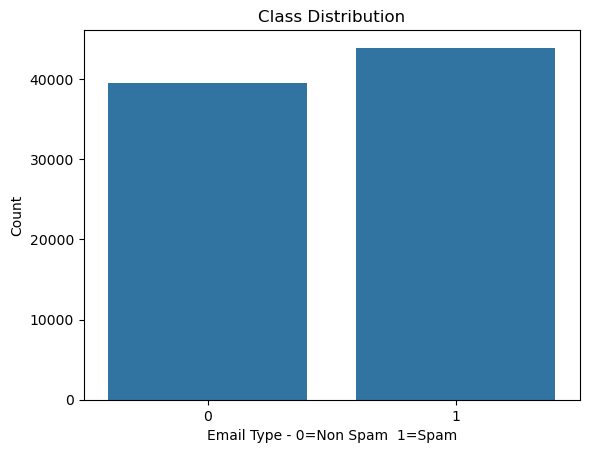

In [38]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.xlabel("Email Type - 0=Non Spam  1=Spam")
plt.ylabel("Count")
plt.show()

In [39]:
# Explore nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [40]:
# Get English stop words and instantiate WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to convert text to lowercase, remove punctuation marks, remove all digits,
# tokenize the text into individual words, remove stop words and reduce words to their base form. 
def clean_text(text):    
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to extract the following features from the text: Average of the word count per row, Indicator about the text having links,
# Indicator to tell if there are special words that indicate spam, 
# Counts of the following: Characters and words, Punctuation marks, Number of digits, and Number of stopwords.

def extract_features(text):
    words = word_tokenize(text)
    return {
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'has_links': int(bool(re.search(r"http[s]?://|www\.", text.lower()))),
        'has_special_offer_words': int(any(word in text.lower() for word in ['free', 'win', 'cash', 'credit', 'prize', 'offer', 'urgent'])),
        'char_count': len(text),
        'word_count': len(words),
        'num_punctuation': sum(1 for c in text if c in string.punctuation),
        'num_digits': sum(1 for c in text if c.isdigit()),
        'num_stopwords': sum(1 for w in words if w.lower() in stop_words)
    }

In [41]:
# Apply extract_features to DataFrame 
engineered_df = df['text'].apply(lambda x: pd.Series(extract_features(x)))

# Add Engineered Features to the original DataFrame
df = pd.concat([df, engineered_df], axis=1)
df.head()

,label,text,avg_word_length,has_links,has_special_offer_words,char_count,word_count,num_punctuation,num_digits,num_stopwords
0,1,ounce feather bowl hummingbird opec moment ala...,6.450000,0.0,0.0,148.0,20.0,0.0,0.0,0.0
1,1,wulvob get your medircations online qnb ikud v...,6.788462,0.0,0.0,808.0,104.0,1.0,0.0,25.0
2,0,computer connection from cnn com wednesday es...,5.612426,0.0,1.0,2235.0,338.0,1.0,0.0,62.0
3,1,university degree obtain a prosperous future m...,6.789474,0.0,1.0,592.0,76.0,0.0,0.0,21.0
4,0,thanks for all your answers guys i know i shou...,5.112108,0.0,0.0,1362.0,223.0,32.0,0.0,50.0


In [42]:
# Apply the function clean_text to the text column, add a new column with the clean data 
df['cleaned_text'] = df['text'].apply(clean_text)


In [43]:
df.head()

,label,text,avg_word_length,has_links,has_special_offer_words,char_count,word_count,num_punctuation,num_digits,num_stopwords,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,6.450000,0.0,0.0,148.0,20.0,0.0,0.0,0.0,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,6.788462,0.0,0.0,808.0,104.0,1.0,0.0,25.0,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,5.612426,0.0,1.0,2235.0,338.0,1.0,0.0,62.0,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,6.789474,0.0,1.0,592.0,76.0,0.0,0.0,21.0,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,5.112108,0.0,0.0,1362.0,223.0,32.0,0.0,50.0,thanks answer guy know checked rsync manual wo...


In [44]:
# Selecting numerical features for the model input
numerical_features = [
    'avg_word_length', 'has_links', 'has_special_offer_words',
    'char_count', 'word_count', 'num_punctuation', 'num_digits', 'num_stopwords'
]
X = df[numerical_features]
y = df['label'] # Target variable

# Data Splitting 
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Preprocessing 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural Network Model Definition 
# Define the architecture of the neural network.

def create_nn_model(input_dim):
    model = Sequential([
        # Input layer and first hidden layer
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3), # Dropout for regularization to prevent overfitting

        # Second hidden layer
        Dense(32, activation='relu'),
        Dropout(0.3),

        # Output layer for binary classification (spam/not spam)
        # Sigmoid activation outputs a probability between 0 and 1
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [45]:
# Get the number of features 
input_dim = X_train_scaled.shape[1]

# Create the model
model = create_nn_model(input_dim)

# Display the model summary
model.summary()

# Training 

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

History = model.fit(
     X_train_scaled,
     y_train,
     epochs=100, # Number of training epochs
     batch_size=32, # Number of samples per gradient update
     validation_split=0.1, # Use a portion of training data for validation
     callbacks=[early_stopping],
     verbose=1 # Show training progress
 )



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step - accuracy: 0.6232 - loss: 0.6422 - val_accuracy: 0.7030 - val_loss: 0.5749
Epoch 2/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.6949 - loss: 0.5851 - val_accuracy: 0.7353 - val_loss: 0.5431
Epoch 3/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.7244 - loss: 0.5530 - val_accuracy: 0.7481 - val_loss: 0.5217
Epoch 4/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.7364 - loss: 0.5376 - val_accuracy: 0.7540 - val_loss: 0.5102
Epoch 5/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - accuracy: 0.7447 - loss: 0.5253 - val_accuracy: 0.7605 - val_loss: 0.5009
Epoch 6/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.7489 - loss: 0.5183 - val_accuracy: 0.7708 - val_loss: 0.4933
Epoch 7/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step - accuracy: 0.7523 - loss: 0.5133 - val_accuracy: 0.7713 - val_loss: 0.4898
Epoch 8/100
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - accuracy: 

In [48]:
# Model Evaluation
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions 
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate precision, recall, F1-score, and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Loss: 0.4412
Test Accuracy: 0.7957
522/522 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
[[6040 1868]
 [1542 7240]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      7908
           1       0.79      0.82      0.81      8782

    accuracy                           0.80     16690
   macro avg       0.80      0.79      0.79     16690
weighted avg       0.80      0.80      0.80     16690



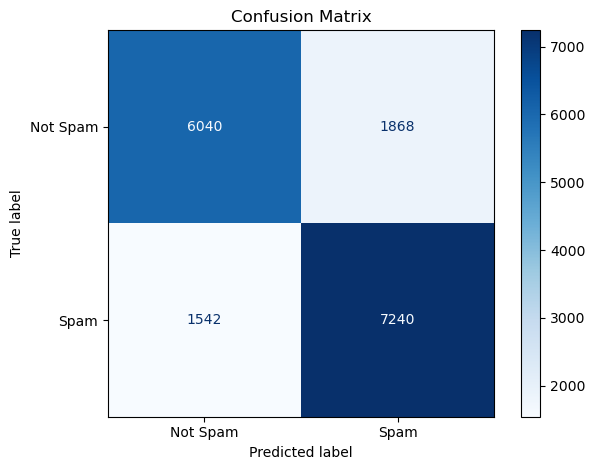

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Not Spam', 'Spam'], cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()